# 1 Setup AND INTIALIZATION

## 1.1 Importing Necessary Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

## 1.2 Loading the Dataset

In [ ]:
data = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding="ISO-8859-1")


# INITIAL DATA ANALYSIS

## 2.1 Dataset overview

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## 2.2 Summary Statistics

In [5]:
# FOR NUMERICAL VARIABLES
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [6]:
# FOR CATEGORICAL VARIABLES
data.describe(include="object").T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


# 3 Data Cleaning & Transformation

## 3.1 Handling missing values


In [7]:
missing_data = data.isna().sum()

# we can divide the missing data with the number of data points with data.shape[0]
missing_percentage = (missing_data[missing_data>0]/data.shape[0]) *100


missing_percentage.sort_values(ascending=True)

Description     0.268311
CustomerID     24.926694
dtype: float64

(0.0, 40.0)

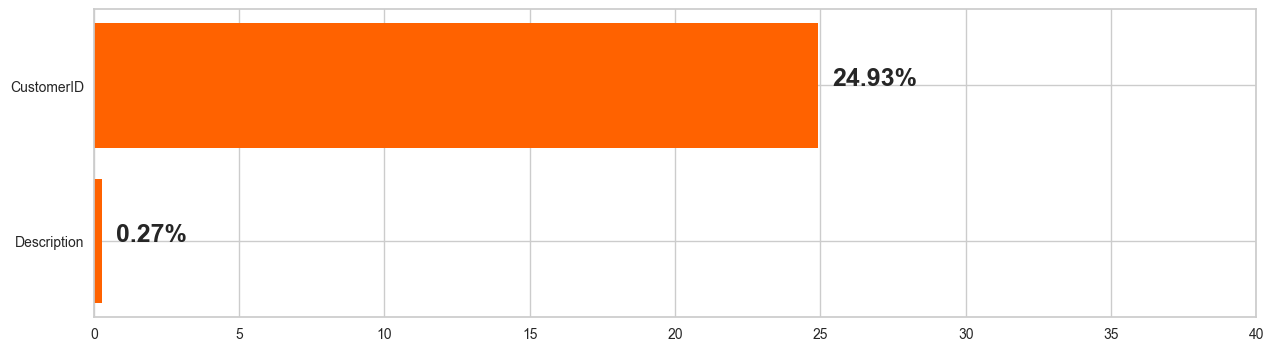

In [8]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')


for i, (value,name) in enumerate(zip(missing_percentage,missing_percentage.index)):

    ax.text(value+0.5,i,f"{value:.2f}%",fontweight="bold",fontsize=18)

# setting the xlim to 40 points
ax.set_xlim([0,40])

### Handling Missing Values Strategy:

CustomerID (24.93% missing values)

The CustomerID column contains nearly a quarter of missing data. This column is essential for clustering customers and creating a recommendation system. Imputing such a large percentage of missing values might introduce significant bias or noise into the analysis.

Moreover, since the clustering is based on customer behavior and preferences, it's crucial to have accurate data on customer identifiers. Therefore, removing the rows with missing CustomerIDs seems to be the most reasonable approach to maintain the integrity of the clusters and the analysis.

Description (0.27% missing values)

The Description column has a minor percentage of missing values. However, it has been noticed that there are inconsistencies in the data where the same StockCode does not always have the same Description. This indicates data quality issues and potential errors in the product descriptions.

Given these inconsistencies, imputing the missing descriptions based on StockCode might not be reliable. Moreover, since the missing percentage is quite low, it would be prudent to remove the rows with missing Descriptions to avoid propagating errors and inconsistencies into the subsequent analyses.

By removing rows with missing values in the CustomerID and Description columns, we aim to construct a cleaner and more reliable dataset, which is essential for achieving accurate clustering and creating an effective recommendation system.

In [9]:
data[data["CustomerID"].isna() | data["Description"].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [10]:
data = data.dropna(subset=["CustomerID","Description"])

In [11]:
# the missing values are not longer are there
data.isna().sum().sum()

0

In [12]:
data.shape

(406829, 8)

## 3.2 Handling of duplicate rows

In [13]:
# Finding duplicate rows (keeping all instances)
# this is only for visulaization purposes where we see the first instance of the row and its duplicates 
duplicated_rows = data[data.duplicated(keep=False)]

# sort it like this to know all the duplicate rows that exists

duplicate_rows_sorted = duplicated_rows.sort_values(by=list(duplicated_rows.columns))

# list(duplicated_rows.columns)

In [14]:
duplicate_rows_sorted.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom


Handling Duplicates Strategy:
In the context of this project, the presence of completely identical rows, including identical transaction times, suggests that these might be data recording errors rather than genuine repeated transactions. Keeping these duplicate rows can introduce noise and potential inaccuracies in the clustering and recommendation system.

Therefore, I am going to remove these completely identical duplicate rows from the dataset. Removing these rows will help in achieving a cleaner dataset, which in turn would aid in building more accurate customer clusters based on their unique purchasing behaviors. Moreover, it would help in creating a more precise recommendation system by correctly identifying the products with the most purchases.

In [15]:
# gets all the duplicated rows
data.duplicated().sum()

5225

In [16]:
data.drop_duplicates(inplace=True)

In [17]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 3.3 Treating Cancelled Transactions

In [18]:
data[data['InvoiceNo'].str.startswith('C')]

# np.where acts as an if else condition where is starts with "C" then canclleed else Completed

data["Transaction"] = np.where(data["InvoiceNo"].str.startswith("C"),"Cancelled","Completed")

In [19]:
cancelled_transactions = data[data['Transaction'] == 'Cancelled']

cancelled_transactions

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,Cancelled
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,Cancelled
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,Cancelled
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,Cancelled
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,Cancelled
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom,Cancelled
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom,Cancelled
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom,Cancelled
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom,Cancelled


In [20]:
cancelled_transactions.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,8872.0,-30.774910,1172.249902,-80995.00,-6.00,-2.00,-1.00,-1.0
UnitPrice,8872.0,18.899512,445.190864,0.01,1.45,2.95,4.95,38970.0
CustomerID,8872.0,14990.152953,1708.230387,12346.00,13505.00,14868.00,16393.00,18282.0


Inferences from the Cancelled Transactions Data:
All quantities in the cancelled transactions are negative, indicating that these are indeed orders that were cancelled.
The UnitPrice column has a considerable spread, showing that a variety of products, from low to high value, were part of the cancelled transactions.

Strategy for Handling Cancelled Transactions:
Considering the project's objective to cluster customers based on their purchasing behavior and preferences and to eventually create a recommendation system, it's imperative to understand the cancellation patterns of customers. Therefore, the strategy is to retain these cancelled transactions in the dataset, marking them distinctly to facilitate further analysis. This approach will:

Enhance the clustering process by incorporating patterns and trends observed in cancellation data, which might represent certain customer behaviors or preferences.
Allow the recommendation system to possibly prevent suggesting products that have a high likelihood of being cancelled, thereby improving the quality of recommendations.

In [21]:
cancelled_percentage = (cancelled_transactions.shape[0]/data.shape[0]) *100

cancelled_percentage

2.209141343213713

## 3.4 Correcting Stock code Anomalies

In [22]:
# Finding the unique stock codes

unique_stock_codes = data["StockCode"].nunique()

unique_stock_codes

3684

In [23]:
# it gives the relative frequency or percentage of each value where the each value is divided by the total number of values of the dataset
data['StockCode'].value_counts(normalize=True) * 100

StockCode
85123A    0.514188
22423     0.471609
85099B    0.413093
47566     0.350843
84879     0.349847
            ...   
90104     0.000249
90135     0.000249
90027D    0.000249
90027A    0.000249
84746     0.000249
Name: proportion, Length: 3684, dtype: float64

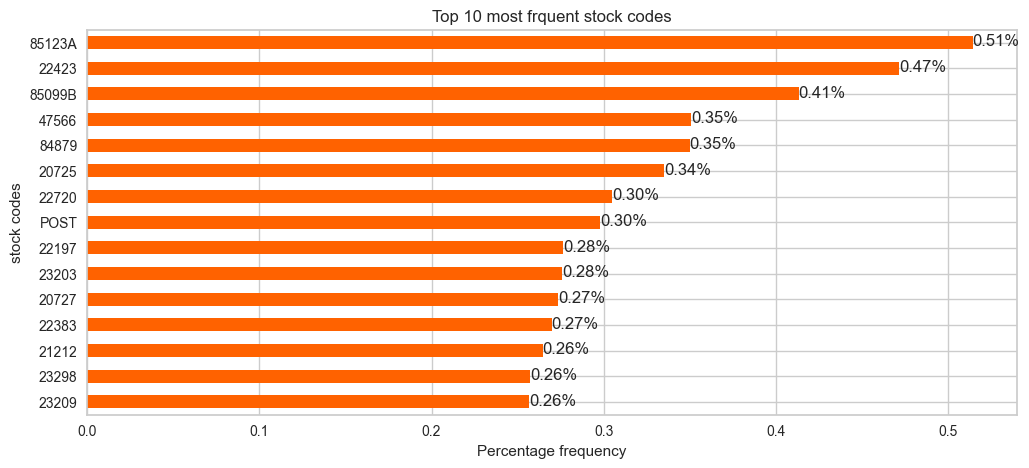

In [24]:
# most frequent stock codes

most_frequent_stock_codes = data['StockCode'].value_counts(normalize=True).head(15) * 100

plt.figure(figsize=(12,5))

most_frequent_stock_codes.plot(kind="barh",color='#ff6200')

for index, value in enumerate(most_frequent_stock_codes):

    plt.text(value,index+0.12, f"{value:.2f}%")
# most_frequent_stock_codes

plt.title("Top 10 most frquent stock codes")
plt.xlabel("Percentage frequency")
plt.ylabel("stock codes")
# inverting the y axis (top to bottom)
plt.gca().invert_yaxis()

plt.show()

Stock Code Anomalies: We observe that while most stock codes are composed of 5 or 6 characters, there are some anomalies like the code 'POST'. These anomalies might represent services or non-product transactions (perhaps postage fees) rather than actual products. To maintain the focus of the project, which is clustering based on product purchases and creating a recommendation system, these anomalies should be further investigated and possibly treated appropriately to ensure data integrity.

In [25]:
unique_stock_codes = data['StockCode'].unique()

unique_stock_codes

array(['85123A', '71053', '84406B', ..., '90214Z', '90089', '23843'],
      dtype=object)

In [26]:
pd.Series(unique_stock_codes).apply(lambda x: x.isdigit())

0       False
1        True
2       False
3       False
4       False
        ...  
3679    False
3680    False
3681    False
3682     True
3683     True
Length: 3684, dtype: bool

In [27]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = data['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


Inference:
The output indicates the following:

A majority of the unique stock codes (3676 out of 3684) contain exactly 5 numeric characters, which seems to be the standard format for representing product codes in this dataset.
There are a few anomalies: 7 stock codes contain no numeric characters and 1 stock code contains only 1 numeric character. These are clearly deviating from the standard format and need further investigation to understand their nature and whether they represent valid product transactions

In [28]:
# above 3676 contain exactly 5  numeirc characters 

# There are a few anomalies: 7 stock codes contain no numeric characters and 1 stock code contains only 1 numeric character. 
# These are clearly deviating from the standard format 
# and need further investigation to understand their nature and whether they represent valid product transactions

In [29]:
#  each index here represents how many characters are not numeric in each index
non_numeric_counts = pd.Series(unique_stock_codes).apply(lambda x: sum(not c.isdigit() for c in str(x))).value_counts()
non_numeric_counts

0     2798
1      880
4        3
2        1
12       1
3        1
Name: count, dtype: int64

In [30]:
#  each index here represents how many characters are numeric in each index
numeric_counts = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()
        
numeric_counts


5    3676
0       7
1       1
Name: count, dtype: int64

In [31]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0,1,2,3)]
anomalous_stock_codes

['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']

In [32]:
# abput 0.476837 percent of stock codes are anamalous
data["StockCode"].isin(anomalous_stock_codes).sum()/len(data) *100

0.4768378801007958

Inference:
Based on the analysis, we find that a very small proportion of the records, 0.48%, have anomalous stock codes, which deviate from the typical format observed in the majority of the data. Also, these anomalous codes are just a fraction among all unique stock codes (only 8 out of 3684).

These codes seem to represent non-product transactions like "BANK CHARGES", "POST" (possibly postage fees), etc. Since they do not represent actual products and are a very small proportion of the dataset, including them in the analysis might introduce noise and distort the clustering and recommendation system.

In [33]:
# removing data with these stock codes which can affect the recommendation system
data[~data["StockCode"].isin(anomalous_stock_codes)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Completed
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,Completed
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,Completed
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,Completed
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,Completed


## 3.5 Cleaning Description Column

In [34]:
most_frequent_descriptions = data["Description"].value_counts()

most_frequent_descriptions

Description
WHITE HANGING HEART T-LIGHT HOLDER    2058
REGENCY CAKESTAND 3 TIER              1894
JUMBO BAG RED RETROSPOT               1659
PARTY BUNTING                         1409
ASSORTED COLOUR BIRD ORNAMENT         1405
                                      ... 
PINK/WHITE GLASS DEMI CHOKER             1
 I LOVE LONDON MINI RUCKSACK             1
SET 36 COLOURING PENCILS DOILEY          1
SET 12 COLOURING PENCILS DOILEY          1
PEARL AND CHERRY QUARTZ BRACLET          1
Name: count, Length: 3896, dtype: int64

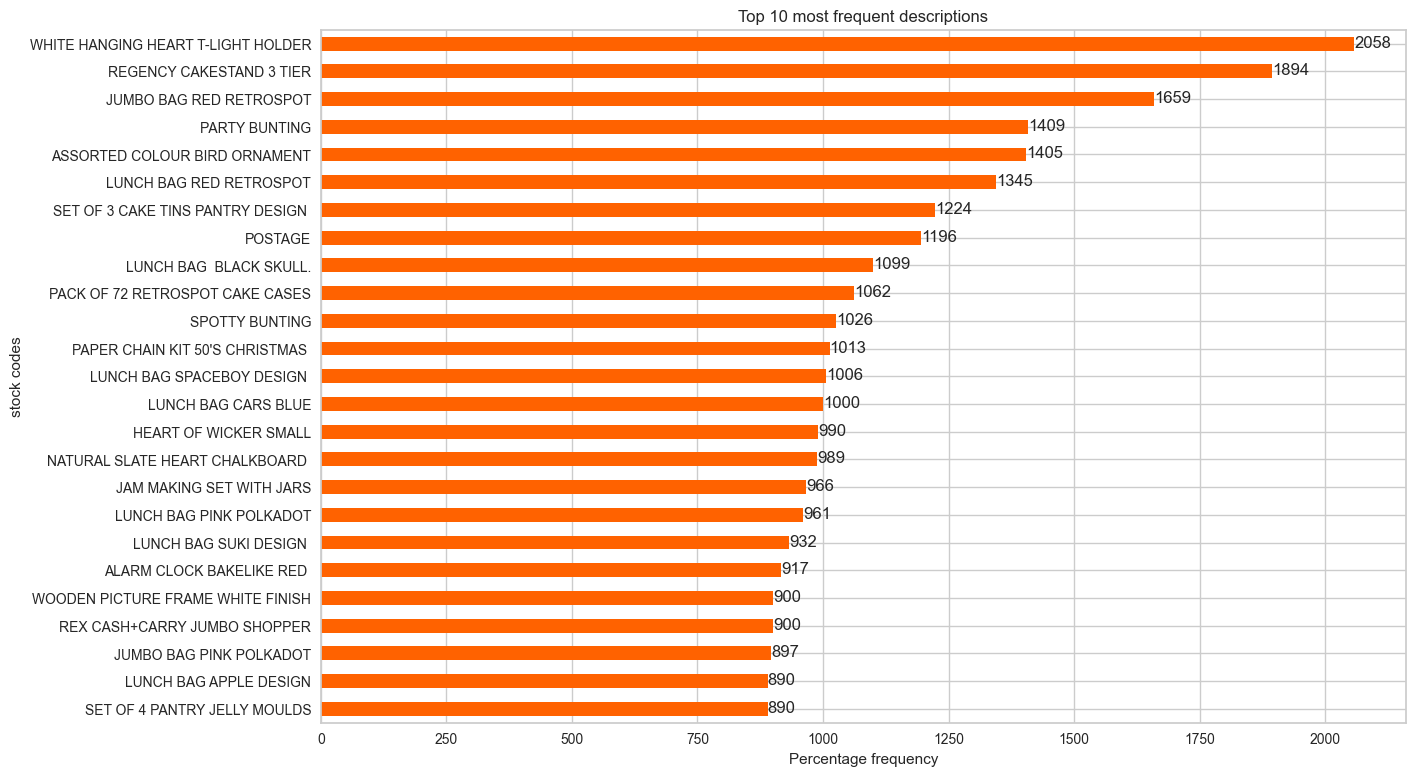

In [35]:
# getting the value counts for the most frequent descriptions made 
most_frequent_descriptions = data["Description"].value_counts().head(25)

plt.figure(figsize=(14,9))

most_frequent_descriptions.plot(kind="barh",color="#ff6200")

for index, value in enumerate(most_frequent_descriptions):

    plt.text(value,index+0.12, f"{value}")
# most_frequent_stock_codes

plt.title("Top 10 most frequent descriptions")
plt.xlabel("Percentage frequency")
plt.ylabel("stock codes")
# inverting the y axis (top to bottom)
plt.gca().invert_yaxis()

plt.show()


Inferences on Descriptions:

The most frequent descriptions are generally household items, particularly those associated with kitchenware, lunch bags, and decorative items.
Interestingly, all the descriptions are in uppercase, which might be a standardized format for entering product descriptions in the database. However, considering the inconsistencies and anomalies encountered in the dataset so far, it would be prudent to check if there are descriptions entered in lowercase or a mix of case styles.

In [36]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = data['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

## HERE WE SEE THE TWO VALUES HIGH RESOLUTION IMAGE AN NEXT DAY CARRAIGE ARE NOT IMPORTANT BELOW

In [37]:
lowercase_descriptions

['Discount',
 'BAG 500g SWIRLY MARBLES',
 'POLYESTER FILLER PAD 45x45cm',
 'POLYESTER FILLER PAD 45x30cm',
 'POLYESTER FILLER PAD 40x40cm',
 'FRENCH BLUE METAL DOOR SIGN No',
 'Manual',
 'BAG 250g SWIRLY MARBLES',
 'BAG 125g SWIRLY MARBLES',
 '3 TRADITIONAl BISCUIT CUTTERS  SET',
 'Bank Charges',
 'NUMBER TILE COTTAGE GARDEN No',
 'FOLK ART GREETING CARD,pack/12',
 'ESSENTIAL BALM 3.5g TIN IN ENVELOPE',
 'POLYESTER FILLER PAD 65CMx65CM',
 'NUMBER TILE VINTAGE FONT No ',
 'POLYESTER FILLER PAD 30CMx30CM',
 'POLYESTER FILLER PAD 60x40cm',
 'FLOWERS HANDBAG blue and orange',
 'Next Day Carriage',
 'THE KING GIFT BAG 25x24x12cm',
 'CRUK Commission',
 'High Resolution Image']

Inference:
Upon reviewing the descriptions that contain lowercase characters, it is evident that some entries are not product descriptions, such as "Next Day Carriage" and "High Resolution Image". These entries seem to be unrelated to the actual products and might represent other types of information or service details.

Strategy:

Step 1: Remove the rows where the descriptions contain service-related information like "Next Day Carriage" and "High Resolution Image", as these do not represent actual products and would not contribute to the clustering and recommendation system we aim to build.

Step 2: For the remaining descriptions with mixed case, standardize the text to uppercase to maintain uniformity across the dataset. This will also assist in reducing the chances of having duplicate entries with different case styles.
By implementing the above strategy, we can enhance the quality of our dataset, making it more suitable for the analysis and modeling phases of our project.

In [38]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

data = data[~data['Description'].isin(service_related_descriptions)]

In [39]:
# Standardize the text to uppercase to maintain uniformity across the dataset
data['Description'] = data['Description'].str.upper()


In [40]:
data.head() 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Completed
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed


## 3.5 Treating Zero Unit Prices

Inference:
The minimum unit price value is zero. This suggests that there are some transactions where the unit price is zero, potentially indicating a free item or a data entry error. To understand their nature, it is essential to investigate these zero unit price transactions further. A detailed analysis of the product descriptions associated with zero unit prices will be conducted to determine if they adhere to a specific pattern:

In [41]:
# checkinng for 0 unit prices
# The transactions with a unit price of zero are relatively few in number (33 transactions).
data[data["UnitPrice"]==0].describe()[['Quantity']]

,Quantity
count,40.000000
mean,347.100000
std,1978.311813
min,1.000000
25%,1.000000
50%,4.500000
75%,24.000000
max,12540.000000


Inferences on UnitPrice:

The transactions with a unit price of zero are relatively few in number (33 transactions).
These transactions have a large variability in the quantity of items involved, ranging from 1 to 12540, with a substantial standard deviation.
Including these transactions in the clustering analysis might introduce noise and could potentially distort the customer behavior patterns identified by the clustering algorithm.

In [42]:
# removing columns with unit price = 0

data = data[data["UnitPrice"]>0]

In [43]:
# Resetting the index of the cleaned dataset
data.reset_index(drop=True, inplace=True)

## FEATURE ENGINEERING

In [44]:
# In order to create a comprehensive customer-centric dataset for clustering and recommendation, 
# the following features can be engineered from the available data:

RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for:

Recency (R): This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.

Frequency (F): This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.

Monetary (M): This metric represents the total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.

Together, these metrics help in understanding a customer's buying behavior and preferences, which is pivotal in personalizing marketing strategies and creating a recommendation system.

### Customer segmentation

## 4.1.1 Recency

Days Since Last Purchase : This feature represents the number of days that have passed since the customer's last purchase. A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business, whereas a higher value may indicate a lapse or decreased engagement. By understanding the recency of purchases, businesses can tailor their marketing strategies to re-engage customers who have not made purchases in a while, potentially increasing customer retention and fostering loyalty.


In [45]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Completed
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed


In [46]:
#  to convert to date time format
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [47]:
data["InvoiceDay"] = data["InvoiceDate"].dt.date

In [48]:
# most recent purchase data, by day for each customer. We do this so grouping by customer
customer_data = data.groupby("CustomerID")["InvoiceDay"].max().reset_index()

In [49]:
# Find the most recent date in the entire dataset
most_recent_date = data['InvoiceDay'].max()

most_recent_date

datetime.date(2011, 12, 9)

In [50]:
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])

In [51]:
# converting most recent day to datetime
most_recent_date = pd.to_datetime(most_recent_date)

most_recent_date

Timestamp('2011-12-09 00:00:00')

In [52]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction,InvoiceDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Completed,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01


In [53]:
customer_data.head()

,CustomerID,InvoiceDay
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02


In [54]:
# this takes into account how many days ago the customer last made a purchase. Note convert to datetime to do this
customer_data["Days_since_last_purchase"] = (most_recent_date - customer_data["InvoiceDay"]).dt.days

In [55]:
customer_data.drop(columns=["InvoiceDay"],inplace=True)

In [56]:
customer_data.head()

,CustomerID,Days_since_last_purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In this step, create two features that quantify the frequency of a customer's engagement with the retailer:

Total Transactions: This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.

Total Products Purchased: This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.

In [57]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction,InvoiceDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Completed,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01


In [58]:
data["InvoiceNo"].value_counts()

InvoiceNo
576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
548316       1
C548307      1
548245       1
548223       1
C546664      1
Name: count, Length: 22182, dtype: int64

## 4.1.2 Frequency

In this step, I am going to create two features that quantify the frequency of a customer's engagement with the retailer:

Total Transactions: This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.
Total Products Purchased: This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.
These features will be crucial in segmenting customers based on their buying frequency, which is a key aspect in determining customer segments for targeted marketing and personalized recommendations.

In [59]:
# grouping customer unique invoice numbers (how many unique invoices they have vs count)
total_transactions = data.groupby("CustomerID")["InvoiceNo"].nunique().reset_index()

total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)


In [60]:
# total produxts purchased 

total_products_purchased = data.groupby("CustomerID")["Quantity"].sum().reset_index()

total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')


customer_data.head(5)


,CustomerID,Days_since_last_purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2341
3,12349.0,18,1,631
4,12350.0,310,1,197


In [61]:
total_products_purchased

,CustomerID,Total_Products_Purchased
0,12346.0,0
1,12347.0,2458
2,12348.0,2341
3,12349.0,631
4,12350.0,197
...,...,...
4366,18280.0,45
4367,18281.0,54
4368,18282.0,98
4369,18283.0,1357


## 4.1.3 Monetary

In this step, I am going to create two features that represent the monetary aspect of customer's transactions:

Total Spend: This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.

Average Transaction Value: This feature is calculated as the Total Spend divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.

In [62]:
# Calculate the total spend by each customer
data['Total_Spend'] = data['UnitPrice'] * data['Quantity']
total_spend = data.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_since_last_purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2341,1797.24,449.310000
3,12349.0,18,1,631,1757.55,1757.550000
4,12350.0,310,1,197,334.40,334.400000


## 4.2 Product Diversity

Unique Products Purchased: This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.

In [63]:
# number of unique products purchased

unique_products_purchased = data.groupby("CustomerID")["StockCode"].count().reset_index()

unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe

customer_data = pd.merge(customer_data,unique_products_purchased,on="CustomerID")

customer_data


,CustomerID,Days_since_last_purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,2
1,12347.0,2,7,2458,4310.00,615.714286,182
2,12348.0,75,4,2341,1797.24,449.310000,31
3,12349.0,18,1,631,1757.55,1757.550000,73
4,12350.0,310,1,197,334.40,334.400000,17
...,...,...,...,...,...,...,...
4366,18280.0,277,1,45,180.60,180.600000,10
4367,18281.0,180,1,54,80.82,80.820000,7
4368,18282.0,7,3,98,176.60,58.866667,13
4369,18283.0,3,16,1357,2045.53,127.845625,721


In [64]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction,InvoiceDay,Total_Spend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Completed,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34


## 4.3 Behavioral Features

In this step, we aim to understand and capture the shopping patterns and behaviors of customers. These features will give us insights into the customers' preferences regarding when they like to shop, which can be crucial information for personalizing their shopping experience. Here are the features I am planning to introduce:

Average Days Between Purchases: This feature represents the average number of days a customer waits before making another purchase. Understanding this can help in predicting when the customer is likely to make their next purchase, which can be a crucial metric for targeted marketing and personalized promotions.

Favorite Shopping Day: This denotes the day of the week when the customer shops the most. This information can help in identifying the preferred shopping days of different customer segments, which can be used to optimize marketing strategies and promotions for different days of the week.

Favorite Shopping Hour: This refers to the hour of the day when the customer shops the most. Identifying the favorite shopping hour can aid in optimizing the timing of marketing campaigns and promotions to align with the times when different customer segments are most active.

By including these behavioral features in our dataset, we can create a more rounded view of our customers, which will potentially enhance the effectiveness of the clustering algorithm, leading to more meaningful customer segments.

In [65]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction,InvoiceDay,Total_Spend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Completed,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34


In [66]:
# day of the week
data["day_of_week"] = data["InvoiceDate"].dt.day_of_week

data["hour"] = data["InvoiceDate"].dt.hour

In [67]:
data["InvoiceDay"].head(2)

0    2010-12-01
1    2010-12-01
Name: InvoiceDay, dtype: object

In [68]:
data.groupby('CustomerID')['InvoiceDay'].apply(lambda x: x.diff().dropna())  

CustomerID        
12346.0     37510     0 days
12347.0     10408     0 days
            10409     0 days
            10410     0 days
            10411     0 days
                       ...  
18287.0     288234    0 days
            288235    0 days
            314034   16 days
            314035    0 days
            314036    0 days
Name: InvoiceDay, Length: 397110, dtype: timedelta64[ns]

In [69]:
data.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction,InvoiceDay,Total_Spend,day_of_week,hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed,2010-12-01,15.30,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Completed,2010-12-01,22.00,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34,2,8


In [70]:
# this takes each customer id into account and calculates the difference between the various transactions made
#  if 0 days, then many transactions happened on a single day, if there is a difference of 16 days then transactions happened between two 
# differnet days one transaction happening 16 days from the first occured transaction. We 
days_between_purchases = data.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()))

days_between_purchases = days_between_purchases.apply(lambda y:y.days)

days_between_purchases


CustomerID        
12346.0     37510      0
12347.0     10408      0
            10409      0
            10410      0
            10411      0
                      ..
18287.0     288234     0
            288235     0
            314034    16
            314035     0
            314036     0
Name: InvoiceDay, Length: 397110, dtype: int64

In [71]:
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()

average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

In [72]:
average_days_between_purchases

,CustomerID,Average_Days_Between_Purchases
0,12346.0,0.000000
1,12347.0,2.016575
2,12348.0,9.433333
3,12349.0,0.000000
4,12350.0,0.000000
...,...,...
4285,18280.0,0.000000
4286,18281.0,0.000000
4287,18282.0,9.916667
4288,18283.0,0.463889


Favouirte shopping day

In [73]:
# count of number of each day of the week for each customer
favorite_shopping_day = data.groupby(['CustomerID', 'day_of_week']).size().reset_index(name='Count_day_of_week')

In [74]:
favorite_shopping_day.head(10)

,CustomerID,day_of_week,Count_day_of_week
0,12346.0,1,2
1,12347.0,0,47
2,12347.0,1,53
3,12347.0,2,40
4,12347.0,3,42
5,12348.0,1,11
6,12348.0,3,17
7,12348.0,6,3
8,12349.0,0,73
9,12350.0,2,17


In [75]:
# gives the index value answer of where the max occurs
favorite_shopping_day.groupby("CustomerID")["Count_day_of_week"].idxmax()

CustomerID
12346.0        0
12347.0        2
12348.0        6
12349.0        8
12350.0        9
           ...  
18280.0    10660
18281.0    10661
18282.0    10663
18283.0    10667
18287.0    10669
Name: Count_day_of_week, Length: 4371, dtype: int64

In [76]:
# select those rows of where the max occurs
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby("CustomerID")["Count_day_of_week"].idxmax()][["CustomerID","day_of_week"]]

In [77]:
shopping_hour = data.groupby(['CustomerID', 'hour']).size().reset_index(name='hour counts')

favorite_shopping_hour = shopping_hour.loc[shopping_hour.groupby("CustomerID")["hour counts"].idxmax()][["CustomerID","hour"]]

In [78]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

In [79]:
customer_data

,CustomerID,Days_since_last_purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,day_of_week,hour
0,12346.0,325,2,0,0.00,0.000000,2,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,182,2.016575,1,14
2,12348.0,75,4,2341,1797.24,449.310000,31,9.433333,3,19
3,12349.0,18,1,631,1757.55,1757.550000,73,0.000000,0,9
4,12350.0,310,1,197,334.40,334.400000,17,0.000000,2,16
...,...,...,...,...,...,...,...,...,...,...
4285,18280.0,277,1,45,180.60,180.600000,10,0.000000,0,9
4286,18281.0,180,1,54,80.82,80.820000,7,0.000000,6,10
4287,18282.0,7,3,98,176.60,58.866667,13,9.916667,4,13
4288,18283.0,3,16,1357,2045.53,127.845625,721,0.463889,3,14


In [80]:
data["Country"].value_counts(normalize=True).head()

Country
United Kingdom    0.888266
Germany           0.023605
France            0.021107
EIRE              0.018614
Spain             0.006294
Name: proportion, dtype: float64

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401481 entries, 0 to 401480
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401481 non-null  object        
 1   StockCode    401481 non-null  object        
 2   Description  401481 non-null  object        
 3   Quantity     401481 non-null  int64         
 4   InvoiceDate  401481 non-null  datetime64[ns]
 5   UnitPrice    401481 non-null  float64       
 6   CustomerID   401481 non-null  float64       
 7   Country      401481 non-null  object        
 8   Transaction  401481 non-null  object        
 9   InvoiceDay   401481 non-null  object        
 10  Total_Spend  401481 non-null  float64       
 11  day_of_week  401481 non-null  int32         
 12  hour         401481 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(2), int64(1), object(6)
memory usage: 36.8+ MB


## 4.4 Geographical Features

In this step, we will introduce a geographic feature that reflects the geographical location of customers. Understanding the geographic distribution of customers is pivotal for several reasons:

Country: This feature identifies the country where each customer is located. Including the country data can help us understand region-specific buying patterns and preferences. Different regions might have varying preferences and purchasing behaviors which can be critical in personalizing marketing strategies and inventory planning. Furthermore, it can be instrumental in logistics and supply chain optimization, particularly for an online retailer where shipping and delivery play a significant role.

In [82]:
# number of transactions per customer in each country
customer_country = data.groupby(['CustomerID',"Country"]).size().reset_index(name='number of Transaction')

In [83]:
# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
main_customer_country = customer_country.sort_values('number of Transaction',ascending=False).drop_duplicates('CustomerID')

In [84]:
main_customer_country["is_UK"] = main_customer_country["Country"].apply(lambda x: 1 if x == "United Kingdom" else 0)

In [85]:
main_customer_country

,CustomerID,Country,number of Transaction,is_UK
4049,17841.0,United Kingdom,7812,1
1902,14911.0,EIRE,5896,0
1307,14096.0,United Kingdom,5128,1
338,12748.0,United Kingdom,4458,1
1681,14606.0,United Kingdom,2759,1
...,...,...,...,...
800,13391.0,United Kingdom,1,1
611,13135.0,United Kingdom,1,1
4294,18174.0,United Kingdom,1,1
2945,16323.0,United Kingdom,1,1


In [86]:
customer_data = pd.merge(customer_data, main_customer_country[['CustomerID', 'is_UK']], on='CustomerID', how='left')

In [87]:
customer_data.head(2)

,CustomerID,Days_since_last_purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,day_of_week,hour,is_UK
0,12346.0,325,2,0,0.0,0.000000,2,0.000000,1,10,1
1,12347.0,2,7,2458,4310.0,615.714286,182,2.016575,1,14,0


## 4.5  Cancellation Insights

In this step, I am going to delve deeper into the cancellation patterns of customers to gain insights that can enhance our customer segmentation model. The features I am planning to introduce are:

Cancellation Frequency: This metric represents the total number of transactions a customer has canceled. Understanding the frequency of cancellations can help us identify customers who are more likely to cancel transactions. This could be an indicator of dissatisfaction or other issues, and understanding this can help us tailor strategies to reduce cancellations and enhance customer satisfaction.

Cancellation Rate: This represents the proportion of transactions that a customer has canceled out of all their transactions. This metric gives a normalized view of cancellation behavior. A high cancellation rate might be indicative of an unsatisfied customer segment. By identifying these segments, we can develop targeted strategies to improve their shopping experience and potentially reduce the cancellation rate.

In [88]:
# total number of unique transactions made
data.groupby('CustomerID')["InvoiceNo"].nunique().reset_index()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1
...,...,...
4366,18280.0,1
4367,18281.0,1
4368,18282.0,3
4369,18283.0,16


In [89]:
cancelled_transactions = data[data["Transaction"] == "Cancelled"]

cancelled_transactions

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction,InvoiceDay,Total_Spend,day_of_week,hour
141,C536379,D,DISCOUNT,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,Cancelled,2010-12-01,-27.50,2,9
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,Cancelled,2010-12-01,-4.65,2,9
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,Cancelled,2010-12-01,-19.80,2,10
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,Cancelled,2010-12-01,-6.96,2,10
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,Cancelled,2010-12-01,-6.96,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
401036,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,Cancelled,2011-12-09,-9.13,4,9
401120,C581499,M,MANUAL,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,Cancelled,2011-12-09,-224.69,4,10
401287,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,Cancelled,2011-12-09,-54.75,4,11
401288,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,Cancelled,2011-12-09,-1.25,4,11


In [90]:
total_transactions = data.groupby('CustomerID')['InvoiceNo'].count().reset_index()

In [91]:
cancellation_frequency = cancelled_transactions.groupby("CustomerID")["InvoiceNo"].count().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)
cancellation_frequency


,CustomerID,Cancellation_Frequency
0,12346.0,1
1,12352.0,10
2,12359.0,6
3,12362.0,8
4,12365.0,1
...,...,...
1584,18272.0,4
1585,18274.0,11
1586,18276.0,2
1587,18277.0,1


In [92]:
# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

In [93]:
# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

In [94]:
customer_data.head(10)

,CustomerID,Days_since_last_purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,day_of_week,hour,is_UK,Cancellation_Frequency
0,12346.0,325,2,0,0.00,0.000000,2,0.000000,1,10,1,1.0
1,12347.0,2,7,2458,4310.00,615.714286,182,2.016575,1,14,0,0.0
2,12348.0,75,4,2341,1797.24,449.310000,31,9.433333,3,19,0,0.0
3,12349.0,18,1,631,1757.55,1757.550000,73,0.000000,0,9,0,0.0
4,12350.0,310,1,197,334.40,334.400000,17,0.000000,2,16,0,0.0
5,12352.0,36,11,470,1545.41,140.491818,95,2.765957,1,14,0,10.0
6,12353.0,204,1,20,89.00,89.000000,4,0.000000,3,17,0,0.0
7,12354.0,232,1,530,1079.40,1079.400000,58,0.000000,3,13,0,0.0
8,12355.0,214,1,240,459.40,459.400000,13,0.000000,0,13,0,0.0
9,12356.0,22,3,1591,2811.43,937.143333,59,5.224138,1,9,0,0.0


In [95]:
# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

In [96]:
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month

In [97]:
new_data = data.copy()

## 4.6 Seasonality trends

Monthly_Spending_Mean: This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer. A higher mean indicates a customer who spends more, potentially showing interest in premium products, whereas a lower mean might indicate a more budget-conscious customer.

Monthly_Spending_Std: This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases. In contrast, a lower value suggests more stable, consistent spending habits. Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend more.

Spending_Trend: This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data. A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction. Conversely, a negative trend might signal decreasing interest or satisfaction, highlighting a need for re-engagement strategies. A near-zero value signifies stable spending habits. Recognizing these trends can help in developing strategies to either maintain or alter customer spending patterns, enhancing the effectiveness of marketing campaigns.

In [98]:

# Calculate monthly spending for each customer
monthly_spending = data.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

In [99]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

### 5 OUTLIER DETECTION AND TREATMENT

In this section, I will identify and handle outliers in our dataset. Outliers are data points that are significantly different from the majority of other points in the dataset. These points can potentially skew the results of our analysis, especially in k-means clustering where they can significantly influence the position of the cluster centroids. Therefore, it is essential to identify and treat these outliers appropriately to achieve more accurate and meaningful clustering results.

Given the multi-dimensional nature of the data, it would be prudent to use algorithms that can detect outliers in multi-dimensional spaces. I am going to use the Isolation Forest algorithm for this task. This algorithm works well for multi-dimensional data and is computationally efficient. It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

In [100]:
model = IsolationForest(contamination=0.05, random_state=0)

In [101]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
# model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:])

In [102]:
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

In [103]:
customer_data['Is_Outlier'] 

0       0
1       0
2       0
3       1
4       0
       ..
4285    0
4286    0
4287    0
4288    0
4289    0
Name: Is_Outlier, Length: 4290, dtype: int64

In [104]:
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

In [105]:
outlier_percentage

Is_Outlier
0    94.988345
1     5.011655
Name: proportion, dtype: float64

In [106]:
customer_data['Is_Outlier'].value_counts(normalize=True)

Is_Outlier
0    0.949883
1    0.050117
Name: proportion, dtype: float64

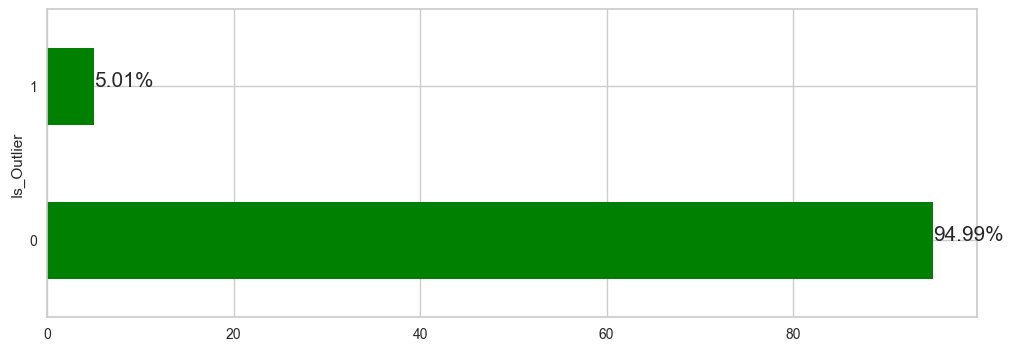

In [107]:
# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind="barh",color="green")
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

Let's proceed with the following steps:

Separate the identified outliers for further analysis and save them as a separate file (optional).

Remove the outliers from the main dataset to prevent them from influencing the clustering process.

Drop the Outlier_Scores and Is_Outlier columns as they were auxiliary columns used for the outlier detection process.

In [108]:
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

In [109]:
outliers_data

,CustomerID,Days_since_last_purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,day_of_week,hour,is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
3,12349.0,18,1,631,1757.55,1757.55,73,0.0,0,9,0,0,0.0,1757.55,0.0,0.0,-1,1
9,12356.0,22,3,1591,2811.43,937.143333,59,5.224138,1,9,0,0,0.0,937.143333,1174.89425,-1106.635,-1,1
10,12357.0,33,1,2708,6207.67,6207.67,131,0.0,6,16,0,0,0.0,6207.67,0.0,0.0,-1,1
12,12359.0,7,6,1599,6182.98,1030.496667,251,1.296,3,12,0,6,0.023904,1030.496667,1137.566659,25.072571,-1,1
26,12377.0,315,2,944,1628.12,814.06,77,0.513158,0,9,0,0,0.0,814.06,265.108474,-374.92,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4167,18118.0,10,31,2860,5567.03,179.581613,1268,0.283346,4,12,1,5,0.15625,506.093636,247.195399,-1.340727,-1,1
4182,18139.0,17,8,5461,8393.22,1049.1525,162,0.006211,0,14,1,3,0.090909,8393.22,0.0,0.0,-1,1
4206,18172.0,14,25,3170,7490.17,299.6068,197,1.428571,3,16,1,8,8.0,749.017,662.724908,-29.045152,-1,1
4243,18223.0,1,27,2890,6315.23,233.897407,299,1.197987,0,9,1,27,0.375,574.111818,465.045777,14.722182,-1,1


In [110]:
# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

In [111]:
customer_data_cleaned.head(10)

,CustomerID,Days_since_last_purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,day_of_week,hour,is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,2,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,182,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2341,1797.24,449.31,31,9.433333,3,19,0,0,0.0,449.31,301.159918,-160.884,1,0
4,12350.0,310,1,197,334.4,334.4,17,0.0,2,16,0,0,0.0,334.4,0.0,0.0,1,0
5,12352.0,36,11,470,1545.41,140.491818,95,2.765957,1,14,0,10,0.105263,386.3525,164.216299,37.351,1,0
6,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0,1,0
7,12354.0,232,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0,1,0
8,12355.0,214,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0,1,0
11,12358.0,1,2,248,1168.06,584.03,19,8.277778,1,10,0,0,0.0,584.03,140.247559,198.34,1,0
13,12360.0,52,3,1165,2662.06,887.353333,129,1.15625,1,15,0,0,0.0,887.353333,306.054391,-19.9,1,0


In [112]:
# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

In [113]:
# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [114]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape[0]

4075

# 6 Correlation Analysis

Before we proceed to KMeans clustering, it's essential to check the correlation between features in our dataset. The presence of multicollinearity, where features are highly correlated, can potentially affect the clustering process by not allowing the model to learn the actual underlying patterns in the data, as the features do not provide unique information. This could lead to clusters that are not well-separated and meaningful.

If we identify multicollinearity, we can utilize dimensionality reduction techniques like PCA. These techniques help in neutralizing the effect of multicollinearity by transforming the correlated features into a new set of uncorrelated variables, preserving most of the original data's variance. This step not only enhances the quality of clusters formed but also makes the clustering process more computationally efficient.

In [115]:
# Reset background style
sns.set_style('whitegrid')

In [116]:
customer_data_cleaned.head(10)

,CustomerID,Days_since_last_purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,day_of_week,hour,is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,2,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,182,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2341,1797.24,449.31,31,9.433333,3,19,0,0,0.0,449.31,301.159918,-160.884
3,12350.0,310,1,197,334.4,334.4,17,0.0,2,16,0,0,0.0,334.4,0.0,0.0
4,12352.0,36,11,470,1545.41,140.491818,95,2.765957,1,14,0,10,0.105263,386.3525,164.216299,37.351
5,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0
6,12354.0,232,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
7,12355.0,214,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0
8,12358.0,1,2,248,1168.06,584.03,19,8.277778,1,10,0,0,0.0,584.03,140.247559,198.34
9,12360.0,52,3,1165,2662.06,887.353333,129,1.15625,1,15,0,0,0.0,887.353333,306.054391,-19.9


In [117]:
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

In [118]:
# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

In [119]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=12)] = True

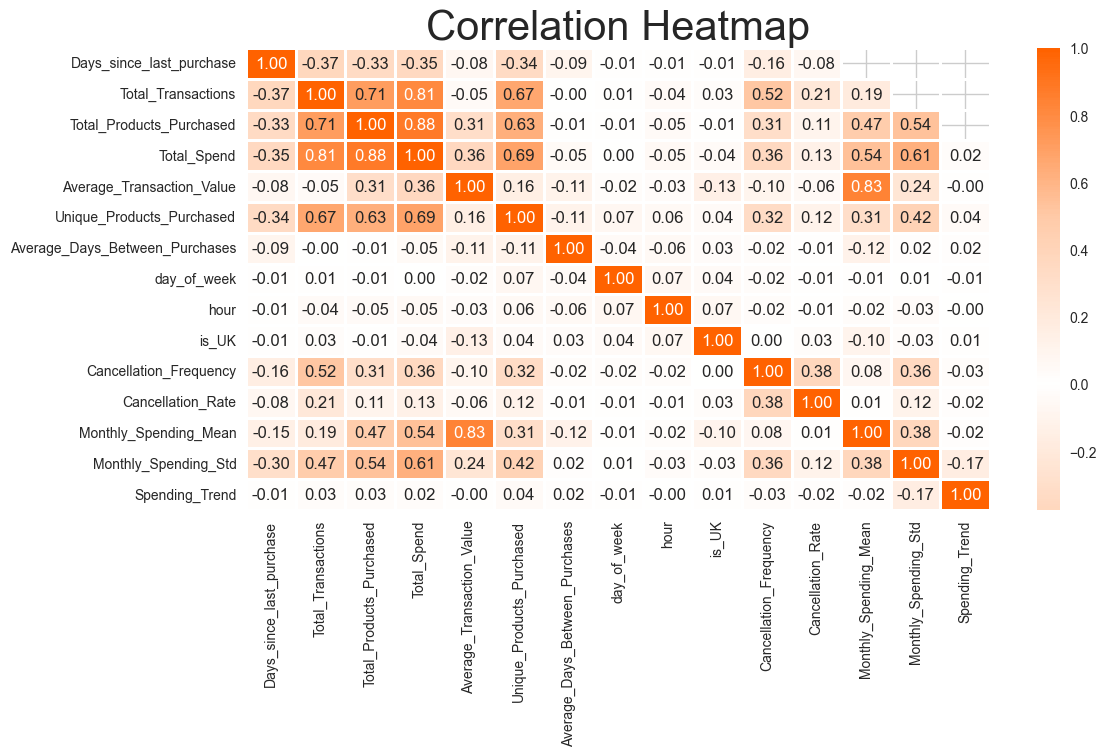

In [120]:
# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr,mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Heatmap',fontsize=30)
plt.show()

# 7 Feature Scaling

Before we move forward with the clustering and dimensionality reduction, it's imperative to scale our features. This step holds significant importance, especially in the context of distance-based algorithms like K-means and dimensionality reduction methods like PCA. Here's why:

For K-means Clustering: K-means relies heavily on the concept of 'distance' between data points to form clusters. When features are not on a similar scale, features with larger values can disproportionately influence the clustering outcome, potentially leading to incorrect groupings.

For PCA: PCA aims to find the directions where the data varies the most. When features are not scaled, those with larger values might dominate these components, not accurately reflecting the underlying patterns in the data.

Therefore, to ensure a balanced influence on the model and to reveal the true patterns in the data, I am going to standardize our data, meaning transforming the features to have a mean of 0 and a standard deviation of 1. However, not all features require scaling. Here are the exceptions and the reasons why they are excluded:

CustomerID: This feature is just an identifier for the customers and does not contain any meaningful information for clustering.

Is_UK: This is a binary feature indicating whether the customer is from the UK or not. Since it already takes a value of 0 or 1, scaling it won't make any significant difference.

Day_Of_Week: This feature represents the most frequent day of the week that the customer made transactions. Since it's a categorical feature represented by integers (1 to 7), scaling it would not be necessary.

In [121]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

In [122]:
# this removes all the columns we dont need
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

In [123]:
columns_to_scale

Index(['Average_Days_Between_Purchases', 'Average_Transaction_Value',
       'Cancellation_Frequency', 'Cancellation_Rate',
       'Days_since_last_purchase', 'Monthly_Spending_Mean',
       'Monthly_Spending_Std', 'Spending_Trend', 'Total_Products_Purchased',
       'Total_Spend', 'Total_Transactions', 'Unique_Products_Purchased',
       'day_of_week', 'hour', 'is_UK'],
      dtype='object')

In [124]:
# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_since_last_purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,day_of_week,hour,is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.359712,-0.488219,-0.750003,-0.822116,-1.367139,-0.755655,-0.309266,-0.841001,-1.085833,0.306049,-0.098234,1.239218,-1.298424,-0.728072,0.088710
1,12347.0,-0.903513,0.660315,1.956913,2.328720,1.608864,1.131405,-0.128415,-0.841001,0.647841,-3.267448,-0.401264,-0.206428,0.954183,1.266126,0.114788
2,12348.0,-0.166004,-0.028805,1.828065,0.491761,0.804563,-0.451629,0.536736,0.237545,2.814935,-3.267448,-0.401264,-0.206428,0.345389,1.032772,-0.846535
3,12350.0,2.208169,-0.717925,-0.533053,-0.577652,0.249155,-0.598400,-0.309266,-0.301728,1.514679,-3.267448,-0.401264,-0.206428,-0.075013,-0.728072,0.088710
4,12352.0,-0.560016,1.579143,-0.232407,0.307660,-0.688084,0.219326,-0.061209,-0.841001,0.647841,-3.267448,2.629038,0.097918,0.115057,0.232080,0.305838


In [125]:
customer_data_scaled[columns_to_scale]

,Average_Days_Between_Purchases,Average_Transaction_Value,Cancellation_Frequency,Cancellation_Rate,Days_since_last_purchase,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Total_Products_Purchased,Total_Spend,Total_Transactions,Unique_Products_Purchased,day_of_week,hour,is_UK
0,-0.309266,-1.367139,-0.098234,1.239218,2.359712,-1.298424,-0.728072,0.088710,-0.750003,-0.822116,-0.488219,-0.755655,-0.841001,-1.085833,0.306049
1,-0.128415,1.608864,-0.401264,-0.206428,-0.903513,0.954183,1.266126,0.114788,1.956913,2.328720,0.660315,1.131405,-0.841001,0.647841,-3.267448
2,0.536736,0.804563,-0.401264,-0.206428,-0.166004,0.345389,1.032772,-0.846535,1.828065,0.491761,-0.028805,-0.451629,0.237545,2.814935,-3.267448
3,-0.309266,0.249155,-0.401264,-0.206428,2.208169,-0.075013,-0.728072,0.088710,-0.533053,-0.577652,-0.717925,-0.598400,-0.301728,1.514679,-3.267448
4,-0.061209,-0.688084,2.629038,0.097918,-0.560016,0.115057,0.232080,0.305838,-0.232407,0.307660,1.579143,0.219326,-0.841001,0.647841,-3.267448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4070,-0.309266,-0.494224,-0.401264,-0.206428,1.874774,-0.637694,-0.728072,0.088710,-0.700446,-0.690088,-0.717925,-0.671786,-1.380275,-1.519252,0.306049
4071,-0.309266,-0.976503,-0.401264,-0.206428,0.894796,-1.002742,-0.728072,0.088710,-0.690534,-0.763032,-0.717925,-0.703237,1.855364,-1.085833,0.306049
4072,0.580082,-1.082612,-0.098234,-0.118813,-0.852999,-0.975376,-0.641581,-0.032901,-0.642078,-0.693012,-0.258512,-0.640335,0.776818,0.214423,0.306049
4073,-0.267664,-0.749208,-0.401264,-0.206428,-0.893411,-0.550061,0.239528,0.218535,0.744417,0.673274,2.727676,6.782103,0.237545,0.647841,0.306049


# 8 Dimensionality Reduction

Why We Need Dimensionality Reduction?

Multicollinearity Detected: In the previous steps, we identified that our dataset contains multicollinear features. Dimensionality reduction can help us remove redundant information and alleviate the multicollinearity issue.

Better Clustering with K-means: Since K-means is a distance-based algorithm, having a large number of features can sometimes dilute the meaningful underlying patterns in the data. By reducing the dimensionality, we can help K-means to find more compact and well-separated clusters.

Noise Reduction: By focusing only on the most important features, we can potentially remove noise in the data, leading to more accurate and stable clusters.

Enhanced Visualization: In the context of customer segmentation, being able to visualize customer groups in two or three dimensions can provide intuitive insights. Dimensionality reduction techniques can facilitate this by reducing the data to a few principal components which can be plotted easily.

Which Dimensionality Reduction Method?
In this step, we are considering the application of dimensionality reduction techniques to simplify our data while retaining the essential information. Among various methods such as KernelPCA, ICA, ISOMAP, TSNE, and UMAP, I am starting with PCA (Principal Component Analysis). Here's why:

PCA is an excellent starting point because it works well in capturing linear relationships in the data, which is particularly relevant given the multicollinearity we identified in our dataset. It allows us to reduce the number of features in our dataset while still retaining a significant amount of the information, thus making our clustering analysis potentially more accurate and interpretable. Moreover, it is computationally efficient, which means it won't significantly increase the processing time.

However, it's essential to note that we are keeping our options open. After applying PCA, if we find that the first few components do not capture a significant amount of variance, indicating a loss of vital information, we might consider exploring other non-linear methods. These methods can potentially provide a more nuanced approach to dimensionality reduction, capturing complex patterns that PCA might miss, albeit at the cost of increased computational time and complexity.

In [126]:
customer_data_scaled.head(5)

,CustomerID,Days_since_last_purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,day_of_week,hour,is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.359712,-0.488219,-0.750003,-0.822116,-1.367139,-0.755655,-0.309266,-0.841001,-1.085833,0.306049,-0.098234,1.239218,-1.298424,-0.728072,0.088710
1,12347.0,-0.903513,0.660315,1.956913,2.328720,1.608864,1.131405,-0.128415,-0.841001,0.647841,-3.267448,-0.401264,-0.206428,0.954183,1.266126,0.114788
2,12348.0,-0.166004,-0.028805,1.828065,0.491761,0.804563,-0.451629,0.536736,0.237545,2.814935,-3.267448,-0.401264,-0.206428,0.345389,1.032772,-0.846535
3,12350.0,2.208169,-0.717925,-0.533053,-0.577652,0.249155,-0.598400,-0.309266,-0.301728,1.514679,-3.267448,-0.401264,-0.206428,-0.075013,-0.728072,0.088710
4,12352.0,-0.560016,1.579143,-0.232407,0.307660,-0.688084,0.219326,-0.061209,-0.841001,0.647841,-3.267448,2.629038,0.097918,0.115057,0.232080,0.305838


In [127]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

In [128]:
# Apply PCA
pca = PCA().fit(customer_data_scaled)

In [129]:
explained_variance_ratio  = pca.explained_variance_ratio_

In [130]:
# the first component explains 29 percent variance and 12.4 percent variance
explained_variance_ratio

array([0.29514849, 0.12435142, 0.07862189, 0.07575881, 0.07022417,
       0.06353877, 0.06091416, 0.06023194, 0.0502893 , 0.03846163,
       0.03173333, 0.02434721, 0.01323392, 0.0086472 , 0.00449777])

In [131]:
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

In [132]:
# the cumulative sum explains the sum as in which to which end of components represnets a large percentage upto 98%
cumulative_explained_variance

array([0.29514849, 0.41949991, 0.49812179, 0.57388061, 0.64410477,
       0.70764354, 0.7685577 , 0.82878963, 0.87907894, 0.91754057,
       0.9492739 , 0.97362111, 0.98685503, 0.99550223, 1.        ])

In [133]:
# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

In [134]:
# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

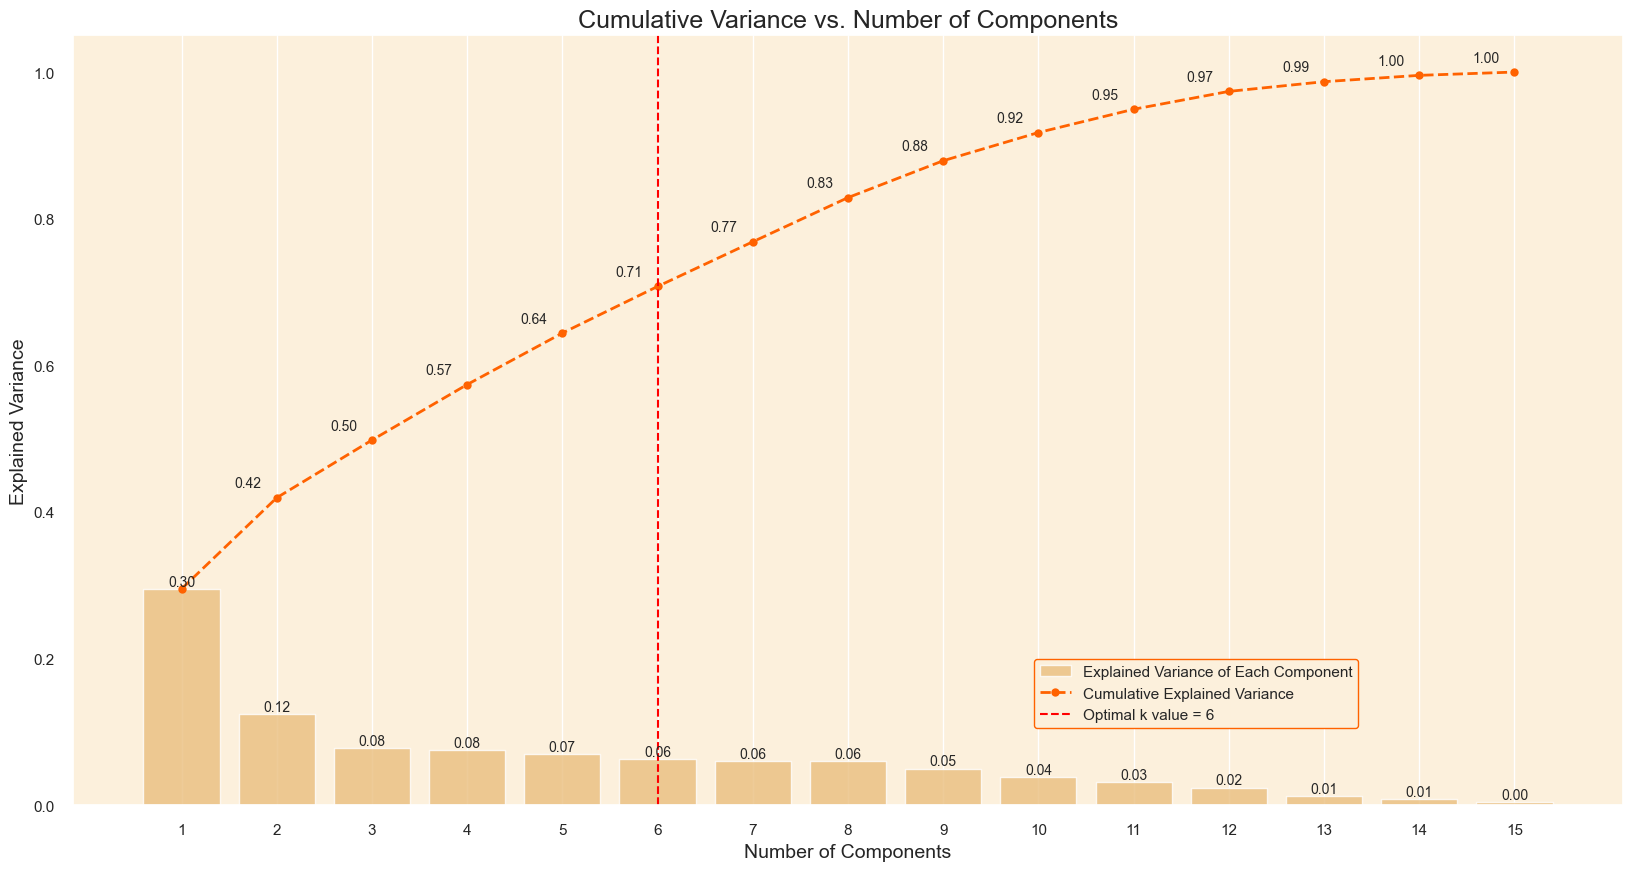

In [135]:
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=range(1, len(cumulative_explained_variance) + 1),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  



# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()


Conclusion
The plot and the cumulative explained variance values indicate how much of the total variance in the dataset is captured by each principal component, as well as the cumulative variance explained by the first n components.

Here, we can observe that:

The first component explains approximately 28% of the variance.

The first two components together explain about 49% of the variance.

The first three components explain approximately 61% of the variance, and so on.

To choose the optimal number of components, we generally look for a point where adding another component doesn't significantly increase the cumulative explained variance, often referred to as the "elbow point" in the curve.

From the plot, we can see that the increase in cumulative variance starts to slow down after the 6th component (which captures about 81% of the total variance).

Considering the context of customer segmentation, we want to retain a sufficient amount of information to identify distinct customer groups effectively. Therefore, retaining the first 6 components might be a balanced choice, as they together explain a substantial portion of the total variance while reducing the dimensionality of the dataset.



In [136]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

In [137]:
# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

In [138]:
customer_data_pca = pd.DataFrame(customer_data_pca, columns=["PC"+str(i+1) for i in range(pca.n_components_)])

In [139]:
# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [140]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.405446,-1.329631,-1.164279,-1.122220,1.145953,0.246221
12347.0,3.637203,2.019696,-0.876803,0.303382,0.480465,-1.222751
12348.0,1.306244,1.434604,0.180673,-0.570693,-1.002386,-0.986765
12350.0,-1.774367,1.440001,-0.349255,-1.382812,1.095962,-1.218902
12352.0,1.499164,-1.204795,-1.531649,-0.966911,1.185573,-1.428876


In [141]:
pca.components_.T

array([[-0.22230158,  0.11275816, -0.01566508, -0.31156305,  0.20021779,
        -0.00218847],
       [ 0.38790748, -0.28897944,  0.01977043,  0.08049358,  0.06668955,
        -0.10666719],
       [ 0.41617387,  0.01751124,  0.02503216,  0.13253163,  0.02534503,
        -0.02062997],
       [ 0.44733935,  0.03062677,  0.01946348,  0.08499073,  0.03717753,
        -0.04079769],
       [ 0.18687381,  0.60808504, -0.03259998, -0.07084544,  0.02010087,
         0.18025933],
       [ 0.36392187, -0.10292052,  0.23474847,  0.05811432,  0.07404715,
        -0.07589381],
       [-0.03000964, -0.14195179, -0.33116957,  0.53418737, -0.33545581,
         0.16267175],
       [ 0.00572547, -0.02582238,  0.51446609, -0.0850168 , -0.19158491,
        -0.56118715],
       [-0.01899174, -0.0298509 ,  0.57780264, -0.1465515 , -0.11940338,
         0.35627384],
       [-0.01508681, -0.19428117,  0.35470162,  0.13412394, -0.18241915,
         0.61054371],
       [ 0.23490605, -0.35094769, -0.17152005, -0.

# 9 K-MEANS CLUSTERING

K-Means is an unsupervised machine learning algorithm that clusters data into a specified number of groups (K) by minimizing the within-cluster sum-of-squares (WCSS), also known as inertia. The algorithm iteratively assigns each data point to the nearest centroid, then updates the centroids by calculating the mean of all assigned points. The process repeats until convergence or a stopping criterion is reached.

To ascertain the optimal number of clusters (k) for segmenting customers, I will explore two renowned methods:

Elbow Method

Silhouette Method

It's common to utilize both methods in practice to corroborate the results.

## 9.1.1 Elbow Method


The Elbow Method is a technique for identifying the ideal number of clusters in a dataset. It involves iterating through the data, generating clusters for various values of k. The k-means algorithm calculates the sum of squared distances between each data point and its assigned cluster centroid, known as the inertia or WCSS score. By plotting the inertia score against the k value, we create a graph that typically exhibits an elbow shape, hence the name "Elbow Method". The elbow point represents the k-value where the reduction in inertia achieved by increasing k becomes negligible, indicating the optimal stopping point for the number of clusters.


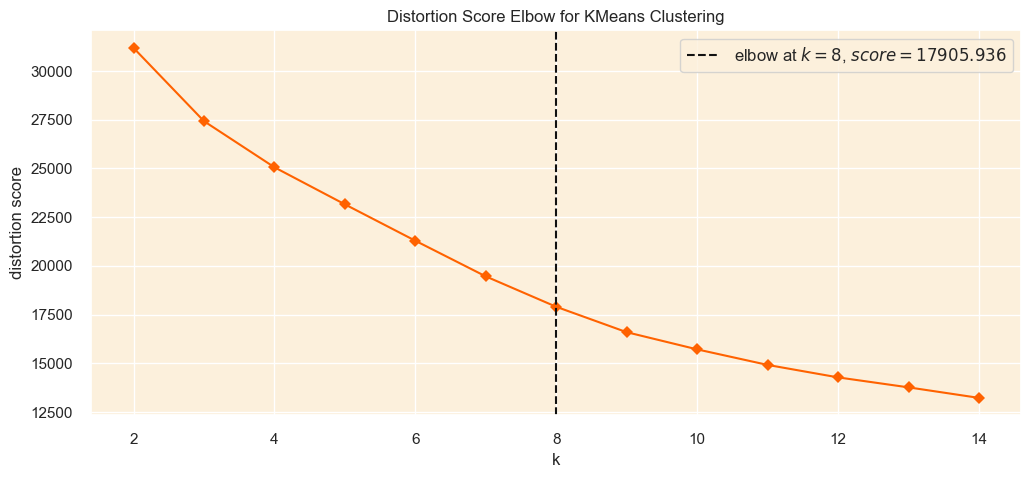

In [142]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

## 9.2 Clustering model k-means

In [143]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [144]:
customer_data_pca

,PC1,PC2,PC3,PC4,PC5,PC6,cluster
CustomerID,,,,,,,
12346.0,-2.405446,-1.329631,-1.164279,-1.122220,1.145953,0.246221,1
12347.0,3.637203,2.019696,-0.876803,0.303382,0.480465,-1.222751,2
12348.0,1.306244,1.434604,0.180673,-0.570693,-1.002386,-0.986765,2
12350.0,-1.774367,1.440001,-0.349255,-1.382812,1.095962,-1.218902,1
12352.0,1.499164,-1.204795,-1.531649,-0.966911,1.185573,-1.428876,2
...,...,...,...,...,...,...,...
18280.0,-2.146836,0.089792,-1.373129,-0.192649,0.908192,0.272698,1
18281.0,-2.151616,-0.594776,0.571349,-0.163428,0.019854,-1.529866,1
18282.0,-1.469887,-1.244878,0.430923,0.613846,-0.609140,-0.355182,1


In [145]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerID,Days_since_last_purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,day_of_week,hour,is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,2,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1
1,12347.0,2,7,2458,4310.0,615.714286,182,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,2
2,12348.0,75,4,2341,1797.24,449.31,31,9.433333,3,19,0,0,0.0,449.31,301.159918,-160.884,2
3,12350.0,310,1,197,334.4,334.4,17,0.0,2,16,0,0,0.0,334.4,0.0,0.0,1
4,12352.0,36,11,470,1545.41,140.491818,95,2.765957,1,14,0,10,0.105263,386.3525,164.216299,37.351,2


# 10 Clustering Evaluation

## 10.1  3D Visualization of Top Principal Components

In this part, I am going to choose the top 3 PCs (which capture the most variance in the data) and use them to create a 3D visualization. This will allow us to visually inspect the quality of separation and cohesion of clusters to some extent:

In [146]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

In [147]:
!pip install --upgrade nbformat

You should consider upgrading via the 'C:\Users\amitt\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [148]:
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

## 10.2 Cluster Distribution Visualization

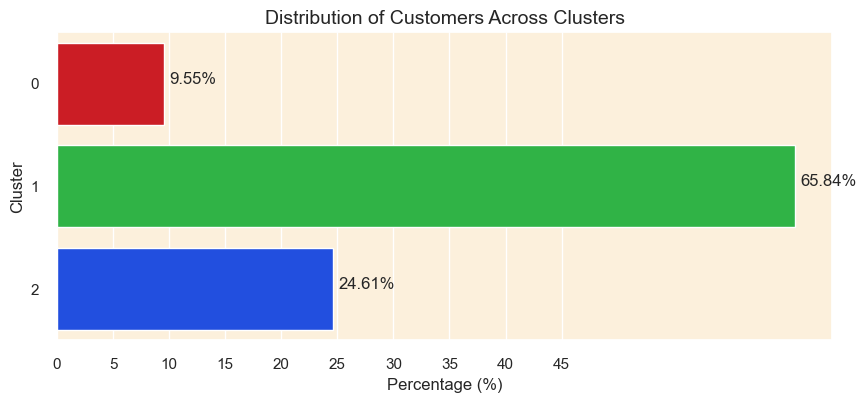

In [149]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

Inference
The distribution of customers across the clusters, as depicted by the bar plot, suggests a fairly balanced distribution with clusters 0 and 1 holding around 41% of customers each and cluster 2 accommodating approximately 18% of the customers.

This balanced distribution indicates that our clustering process has been largely successful in identifying meaningful patterns within the data, rather than merely grouping noise or outliers. It implies that each cluster represents a substantial and distinct segment of the customer base, thereby offering valuable insights for future business strategies.

Moreover, the fact that no cluster contains a very small percentage of customers, assures us that each cluster is significant and not just representing outliers or noise in the data. This setup allows for a more nuanced understanding and analysis of different customer segments, facilitating effective and informed decision-making.

## 10.3 Evaluation Metrics

Silhouette Score: A measure to evaluate the separation distance between the clusters. Higher values indicate better cluster separation. It ranges from -1 to 1.

Calinski Harabasz Score: This score is used to evaluate the dispersion between and within clusters. A higher score indicates better defined clusters.

Davies Bouldin Score: It assesses the average similarity between each cluster and its most similar cluster. Lower values indicate better cluster separation.

In [150]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

In [151]:
sil_score = silhouette_score(X, clusters)

In [152]:
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

In [153]:
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

table_data

[['Number of Observations', 4075],
 ['Silhouette Score', 0.2819436712831763],
 ['Calinski Harabasz Score', 1174.7876899936111],
 ['Davies Bouldin Score', 1.6154427284456583]]

The Silhouette Score of approximately 0.236, although not close to 1, still indicates a fair amount of separation between the clusters. It suggests that the clusters are somewhat distinct, but there might be slight overlaps between them. Generally, a score closer to 1 would be ideal, indicating more distinct and well-separated clusters.

The Calinski Harabasz Score is 1257.17, which is considerably high, indicating that the clusters are well-defined. A higher score in this metric generally signals better cluster definitions, thus implying that our clustering has managed to find substantial structure in the data.

The Davies Bouldin Score of 1.37 is a reasonable score, indicating a moderate level of similarity between each cluster and its most similar one. A lower score is generally better as it indicates less similarity between clusters, and thus, our score here suggests a decent separation between the clusters.

In conclusion, the metrics suggest that the clustering is of good quality, with clusters being well-defined and fairly separated. However, there might still be room for further optimization to enhance cluster separation and definition, potentially by trying other clustering and dimensionality reduction algorithms.

## 11.2 Histogram Chart Approach

To validate the profiles identified from the radar charts, we can plot histograms for each feature segmented by the cluster labels. These histograms will allow us to visually inspect the distribution of feature values within each cluster, thereby confirming or refining the profiles we have created based on the radar charts.

In [154]:
features = customer_data_cleaned.columns[1:-1]

In [155]:
clusters = customer_data_cleaned["cluster"].unique()

clusters.sort()


In [156]:
n_rows = len(features)
n_cols = len(clusters)

n_rows

15

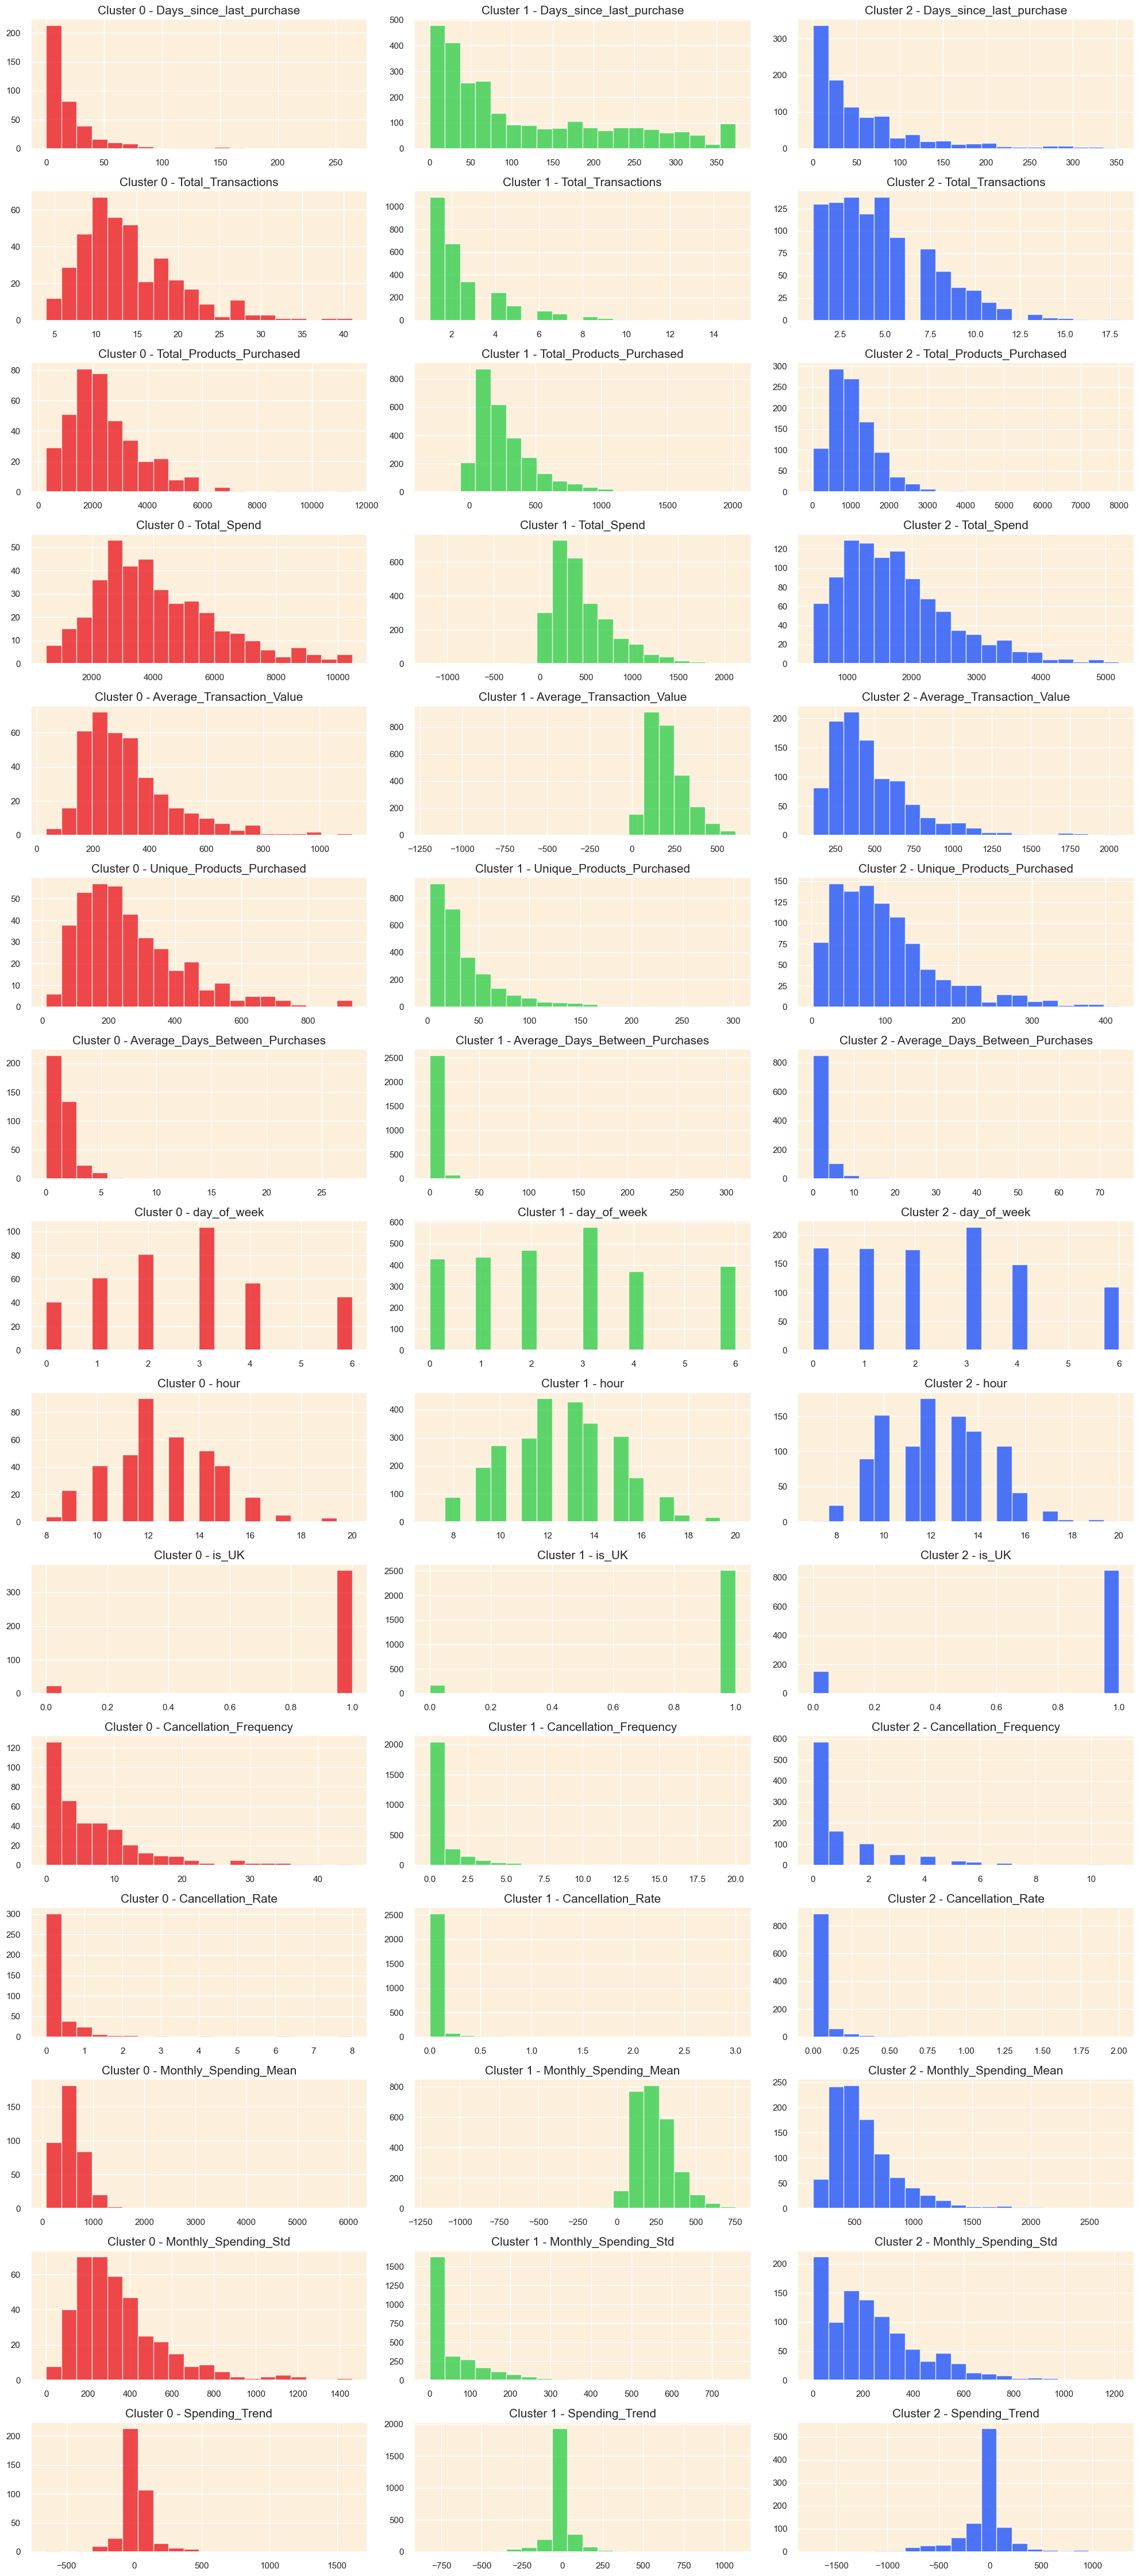

In [157]:
fig, ax = plt.subplots(n_rows,n_cols,figsize=(20,3*n_rows))

for i, feature in enumerate(features):

    for j, cluster in enumerate(clusters):

        data = customer_data_cleaned[customer_data_cleaned["cluster"] == cluster][feature]

        ax[i,j].hist(data, bins=20, color=colors[j], edgecolor="w", alpha=0.7)

        ax[i, j].set_title(f"Cluster {cluster} - {feature}",fontsize=15)

        ax[i, j].set_xlabel('')

        ax[i, j].set_ylabel('')


# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

## 12 Recommendation System

In [158]:
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

In [159]:
customer_data_cleaned.dtypes

CustomerID                        float64
Days_since_last_purchase            Int64
Total_Transactions                  Int64
Total_Products_Purchased            Int64
Total_Spend                       Float64
Average_Transaction_Value         Float64
Unique_Products_Purchased           Int64
Average_Days_Between_Purchases    Float64
day_of_week                         Int32
hour                                Int32
is_UK                               Int64
Cancellation_Frequency              Int64
Cancellation_Rate                 Float64
Monthly_Spending_Mean             Float64
Monthly_Spending_Std              Float64
Spending_Trend                    Float64
cluster                             int32
dtype: object

In [160]:
new_data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction,InvoiceDay,Total_Spend,day_of_week,hour,Year,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed,2010-12-01,15.30,2,8,2010,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34,2,8,2010,12


In [161]:
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = new_data[~new_data['CustomerID'].isin(outlier_customer_ids)]

In [162]:
#  taking out all the outliers in the dataset
df_filtered

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction,InvoiceDay,Total_Spend,day_of_week,hour,Year,Month
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,Completed,2010-12-01,54.08,2,8,2010,12
10,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2010-12-01 08:34:00,2.10,13047.0,United Kingdom,Completed,2010-12-01,12.60,2,8,2010,12
11,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2010-12-01 08:34:00,2.10,13047.0,United Kingdom,Completed,2010-12-01,12.60,2,8,2010,12
12,536367,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,2010-12-01 08:34:00,3.75,13047.0,United Kingdom,Completed,2010-12-01,30.00,2,8,2010,12
13,536367,22310,IVORY KNITTED MUG COSY,6,2010-12-01 08:34:00,1.65,13047.0,United Kingdom,Completed,2010-12-01,9.90,2,8,2010,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401476,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,Completed,2011-12-09,10.20,4,12,2011,12
401477,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,Completed,2011-12-09,12.60,4,12,2011,12
401478,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,Completed,2011-12-09,16.60,4,12,2011,12
401479,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,Completed,2011-12-09,16.60,4,12,2011,12


In [163]:
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

In [164]:
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

In [165]:
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()

In [166]:
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])

In [167]:
best_selling_products

,cluster,StockCode,Description,Quantity
1414,0,22616,PACK OF 12 LONDON TISSUES,14277
1005,0,22178,VICTORIAN GLASS HANGING T-LIGHT,8201
2770,0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,7651
3124,0,85099B,JUMBO BAG RED RETROSPOT,7179
2970,0,84879,ASSORTED COLOUR BIRD ORNAMENT,6867
...,...,...,...,...
9900,2,84750A,PINK SMALL GLASS CAKE STAND,0
10293,2,90070,RUBY GLASS CLUSTER BRACELET,0
7028,2,16202E,BLACK PHOTO ALBUM,-1
10426,2,D,DISCOUNT,-3


In [168]:
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

In [169]:
top_products_per_cluster

,cluster,StockCode,Description,Quantity
1414,0,22616,PACK OF 12 LONDON TISSUES,14277
1005,0,22178,VICTORIAN GLASS HANGING T-LIGHT,8201
2770,0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,7651
3124,0,85099B,JUMBO BAG RED RETROSPOT,7179
2970,0,84879,ASSORTED COLOUR BIRD ORNAMENT,6867
1796,0,22998,TRAVEL CARD WALLET KEEP CALM,5993
982,0,22151,PLACE SETTING WHITE HEART,5885
1025,0,22197,POPCORN HOLDER,5175
11,0,15036,ASSORTED COLOURS SILK FAN,4971
3138,0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,4883


In [170]:
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

In [171]:
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']

In [172]:
for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])

In [173]:
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [174]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
17499.0,16014,SMALL CHINESE STYLE SCISSOR,85099B,JUMBO BAG RED RETROSPOT,84879,ASSORTED COLOUR BIRD ORNAMENT
15572.0,16014,SMALL CHINESE STYLE SCISSOR,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT
13763.0,16014,SMALL CHINESE STYLE SCISSOR,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT
14038.0,16014,SMALL CHINESE STYLE SCISSOR,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT
15288.0,16014,SMALL CHINESE STYLE SCISSOR,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT
17084.0,16014,SMALL CHINESE STYLE SCISSOR,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT
12424.0,16014,SMALL CHINESE STYLE SCISSOR,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT
13396.0,16014,SMALL CHINESE STYLE SCISSOR,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT
13808.0,16014,SMALL CHINESE STYLE SCISSOR,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT
